<a href="https://colab.research.google.com/github/Svar7769/periodic_review_inventory_system/blob/master/RL_inv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AttributeError: 'DataFrame' object has no attribute 'append'

In [18]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Parameters
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 31)
lead_time = 2  # Lead time for order arrival
initial_inventory = 100
max_order = 50
review_period = 7

# Generate dates
dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Create list to store data
data_list = []

# Initialize inventory and order arrival time
inventory_level = initial_inventory
order_arrival_time = 0
order_quantity = 0  # Define order_quantity outside of the loop

for date in dates:
    # Simulate demand
    demand = np.random.randint(0, 20)  # Random demand between 0 and 19

    # Place order if it's a review period
    if date.day % review_period == 0:
        order_quantity = np.random.randint(0, max_order + 1)  # Random order quantity between 0 and max_order
        order_arrival_time = lead_time

    # Update inventory level based on demand and order arrival
    inventory_level = max(inventory_level + order_arrival_time - demand, 0)

    # Update order arrival time
    if order_arrival_time > 0:
        order_arrival_time -= 1

    # Append data to list
    data_list.append({
        'Date': date,
        'Product_ID': 1,  # Assuming Product_ID is 1 for simplicity
        'Demand': demand,
        'Order_Quantity': order_quantity if order_arrival_time == 0 else 0,
        'Order_Arrival_Time': order_arrival_time
    })

# Convert list of dictionaries to DataFrame
data = pd.DataFrame(data_list)

# Convert 'Order_Quantity' and 'Order_Arrival_Time' to integers
data['Order_Quantity'] = data['Order_Quantity'].astype(int)
data['Order_Arrival_Time'] = data['Order_Arrival_Time'].astype(int)

# Display the first few rows of the simulated dataset
print(data.head())


        Date  Product_ID  Demand  Order_Quantity  Order_Arrival_Time
0 2023-01-01           1      15               0                   0
1 2023-01-02           1      18               0                   0
2 2023-01-03           1      13               0                   0
3 2023-01-04           1       5               0                   0
4 2023-01-05           1       3               0                   0


In [89]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
from stable_baselines3 import DQN
from itertools import product
import random
import matplotlib.pyplot as plt


# New Section

In [101]:
import gym
import numpy as np
from gym import spaces

def barGraph(row):
    date = row['Date'].values[0]
    product_id = row['Product_ID'].values[0]
    demand = row['Demand'].values[0]
    order_quantity = row['Order_Quantity'].values[0]
    order_arrival_time = row['Order_Arrival_Time'].values[0]

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(['Demand', 'Order Quantity', 'Order Arrival Time'], [demand, order_quantity, order_arrival_time])
    plt.xlabel('Metrics')
    plt.ylabel('Quantity')
    plt.title(f'Data for Product {product_id} on {date}')
    plt.show()

class InventoryEnv(gym.Env):
    def __init__(self, data):
        super(InventoryEnv, self).__init__()
        self.data = data
        self.product_id = 1  # Assuming Product_ID is 1 for the single-product environment
        self.num_days = data['Date'].nunique()

        # Inventory management parameters
        self.initial_inventory = 50
        self.max_order = 50
        self.holding_cost = 1
        self.shortage_cost = 5
        self.order_cost = 2
        self.review_period = 7
        self.lead_time = 2

        # Define action and observation space
        self.action_space = spaces.Discrete(self.max_order + 1)  # Orders can be from 0 to max_order
        self.observation_space = spaces.Box(low=0, high=self.initial_inventory, shape=(1,), dtype=np.int32)

        self.reset()

    def reset(self):
        self.current_day = 0
        self.inventory_level = self.initial_inventory
        self.total_cost = 0
        return np.array([self.inventory_level])

    def step(self, action):
        order_quantity = action
        # Convert current_day to date
        current_date = self.data['Date'].min() + timedelta(days=self.current_day)
        # Calculate arrival date for the order
        arrival_date = current_date + timedelta(days=self.lead_time)

        print(f'OrderQuantity : {order_quantity}, arrival date : {arrival_date}')

        # Update 'Order_Arrival_Time' for the corresponding product and arrival date
        if arrival_date <= self.data['Date'].max():
            self.data.loc[(self.data['Product_ID'] == self.product_id) & (
                self.data['Date'] == arrival_date), 'Order_Arrival_Time'] = order_quantity

        # Get demand for the current date and product
        demand_today_row = self.data.loc[(self.data['Product_ID'] == self.product_id) & (
            self.data['Date'] == current_date), 'Demand']
        demand_today = demand_today_row.values[0] if not demand_today_row.empty else 0

        print(f'Demand Today : {demand_today}')

        order_today = self.data.loc[(self.data['Product_ID'] == self.product_id) & (
            self.data['Date'] == current_date), 'Order_Arrival_Time'].sum()

        print(f'Order Arriving Today: {order_today}')

        # Adjust inventory levels based on demand
        self.inventory_level = max(self.inventory_level + \
                                   self.data.loc[(self.data['Product_ID'] == self.product_id) & (
                                       self.data['Date'] == current_date), 'Order_Arrival_Time'].sum() - demand_today, 0)

        # Calculate and update costs for the day
        holding_costs = self.holding_cost * self.inventory_level
        shortage_costs = self.shortage_cost * max(demand_today - self.inventory_level, 0)
        ordering_costs = self.order_cost * order_quantity
        self.total_cost += holding_costs + shortage_costs + ordering_costs

        # Move to the next date
        self.current_day += 1
        done = self.current_day >= self.num_days
        reward = -self.total_cost
        return np.array([self.inventory_level]), reward, done, {}

    def plot_inventory_level(self):
        # Calculate inventory levels for each day
        inventory_levels = []
        for day in range(self.num_days):
            inventory_level = self.initial_inventory
            for i in range(day):
                current_date = self.data['Date'].min() + timedelta(days=i)
                demand_today_row = self.data.loc[(self.data['Product_ID'] == self.product_id) & (
                    self.data['Date'] == current_date), 'Demand']
                demand_today = demand_today_row.values[0] if not demand_today_row.empty else 0
                order_today = self.data.loc[(self.data['Product_ID'] == self.product_id) & (
                    self.data['Date'] == current_date), 'Order_Arrival_Time'].sum()
                inventory_level = max(inventory_level + order_today - demand_today, 0)
            inventory_levels.append(inventory_level)

        # Create a line plot
        plt.figure(figsize=(12, 6))
        plt.plot(range(self.num_days), inventory_levels, marker='o')
        plt.xlabel('Day')
        plt.ylabel('Inventory Level')
        plt.title('Inventory Level Over Time')
        plt.grid(True)
        plt.show()


    def render(self, mode='human'):
        current_date = self.data['Date'].min() + timedelta(days=self.current_day)
        print(
              f'Day: {self.current_day}, Inventory Level: {self.inventory_level}, Total Cost: {self.total_cost}')
        row = self.data[(self.data['Product_ID'] == self.product_id) & (self.data['Date'] == current_date)]
        print(row)




Observation space: Box(0, 50, (1,), int32)
Action space: Discrete(51)
Day: 0, Inventory Level: 50, Total Cost: 0


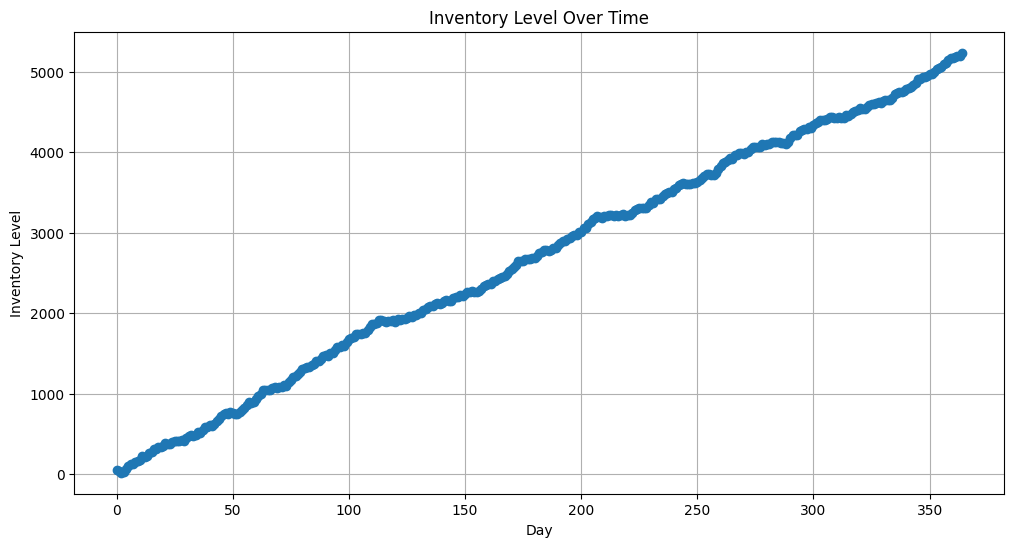

OrderQuantity : 25, arrival date : 2023-01-03 00:00:00
Demand Today : 15
Order Arriving Today: 0
Day: 1, Inventory Level: 35, Total Cost: 85


In [ ]:
# Check if the necessary columns are present
required_columns = ['Date', 'Product_ID', 'Demand', 'Order_Quantity', 'Order_Arrival_Time']
missing_columns = [col for col in required_columns if col not in data.columns]

if missing_columns:
    raise ValueError(f"Missing columns in the dataset: {missing_columns}")

# Initialize the environment with the synthetic data
env = InventoryEnv(data)

# Verify Observation Space and Action Space
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

# Run the environment for a few episodes
episodes = 1
for episode in range(1, episodes + 1):
    state = env.reset()
    done = False
    score = 0
    while not done:
        env.render()
        action = env.action_space.sample()
        # print(f'action : {action}')
        next_state, reward, done, info = env.step(action)
        score += reward
        # print(f'Next state : {next_state}, Reward : {reward}, done : {done}, info: {info}')
        # print(f"Action taken: {action}, Orders: {env.actions[action]}")
    print(f"Episode: {episode} ended with Score: {score}")
    env.plot_inventory_level()



In [ ]:
# Load your dataset here
data_path = '/content/synthetic_inventory_data.csv'
data = pd.read_csv(data_path)

# Check if the necessary columns are present
required_columns = ['Date', 'Product_ID', 'Demand', 'Order_Quantity', 'Order_Arrival_Time', 'Inventory_Level', 'Holding_Cost', 'Shortage_Cost', 'Ordering_Cost', 'Total_Cost']
missing_columns = [col for col in required_columns if col not in data.columns]

if missing_columns:
    raise ValueError(f"Missing columns in the dataset: {missing_columns}")

# Initialize the environment with the synthetic data
env = InventoryEnv(data)

# Train the RL model
model = DQN('MlpPolicy', env, verbose=1, device='cpu')
model.learn(total_timesteps=10000)

# Test the RL model
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    while not done:
        env.render()
        action = random.choice([0, 1])
        n_state, reward, done, _ = env.step(action)
        score += reward
    print('Episode:{} Score:{}'.format(episode, score))

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
